In [1]:
## load required packages ##
import os
import matplotlib.pyplot as plt
import pylab as p
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from os import listdir
import csv
import math
import pandas as pd
import scipy.integrate 
import scipy.io as sio
from IPython.core.display import display, HTML
from __future__ import division
import pickle
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyamg
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
## EDIT THIS SECTION | FILE & DIRECTORY INFO, HOUSEKEEPING ##
basedir1 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\FigS4 water\\LHb"
basedir2 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\FigS4 water\\VTA"
condition = ['LHb','VTA']
projection='Both'

lickalignfile='fissa_lick_align.npy'  #Lick aligned file name

fissa=['yes'] ## are the files fissa decontaminated?

filename='Water' ## name to be appended to saved files/figs

## Save Figures?
save_figs=['yes']

## Fig file type
fig_style='pdf' ##png, pdf, tif

## Save data files?
save_files=['yes']

maxnumneurons = 1000 #used to initialize arrays. Should be larger than the total number of neurons
framerate=5

## Color palatte ##
cmap=sns.diverging_palette(200, 275, sep=50, as_cmap=True, center='dark') ##Green-Purple
#cmap = sns.diverging_palette(230, 5, sep=20, as_cmap=True, center='dark') ###Teal-Pink
#cmap=sns.diverging_palette(220, 35, sep=100, as_cmap=True, center='dark') ###Teal-Gold

## Colors for bar/line plots (order reflects order of 'condition' above) ##
colors = ['lightseagreen','magenta']

In [3]:
### EDIT THIS SECTION | SET PARAMS FOR SUCROSE ANALYSIS ###
maxtrials=20    #number of trials
framespertrial=100 #frames per trial in lick align file
numpreframes=35 #frames before first lick

## normalize data by baseline?
normalize_on=['yes']
baseline=[20,35]
test=[35,65] ##used to calc significance

## END NECESSARY EDITS ##

In [4]:
## DO NOT EDIT - set path, create output directories, save params ##
if fissa[0]=='yes':
    filename=filename+'_fissa'
else:
    filename=filename
os.chdir(basedir1)
os.chdir('..')
try:
    os.mkdir(filename+'_OUTPUT')
except OSError:
    print ("Creation of the directory %s failed" % filename+'_OUTPUT')
else:
    print ("Successfully created the directory %s " % filename+'_OUTPUT')
os.chdir(filename+'_OUTPUT')
try:
    os.mkdir('BL')
    os.mkdir('Water')
    os.mkdir('Behavior')
except OSError:
    pass
%pwd

#save parameters to csv
params=['Lick align file: '+str(lickalignfile),'Trials: '+str(maxtrials),'Frames per trial: '+str(framespertrial),
        'Lick occurs at frame: '+str(numpreframes), 'Normalize sucrose by baseline? '+str(normalize_on[0]),
        'Sucrose baseline period (frames): '+str(baseline), 'Sucrose test period (frames): '+str(test),
        'framerate = '+str(framerate)]
with open(filename+'_analysis_parameters.csv','wb') as myfile:
    out=csv.writer(myfile,delimiter=',',dialect='excel',quoting=csv.QUOTE_ALL)
    out.writerow(params)

Creation of the directory Water_fissa failed_OUTPUT


In [5]:
## DO NOT EDIT -  Load files in basedir1 and basedir2 ##
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    trials_pop=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        try:
            signals=np.load(os.path.join(directory,data_dir,lickalignfile))
        except:
            continue
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
        for a in range(0,numneurons):
            signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            trials_pop[numneuronstillnow:numneuronstillnow+a+1]=numtrials
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    trials_pop=trials_pop[:numneuronstillnow]
    print '\nfiles = '+str(data_dirs)
    print 'Number of neurons = '+str(extractedsignals.shape[2])
    print 'Number of frames per trial = '+str(extractedsignals.shape[1])
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials,trials_pop
extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1,trials_pop1=load_files(basedir1)
extractedsignals2,numneuronstillnow2,numframes2,numneurons2,numtrials2,trials_pop2=load_files(basedir2)


files = ['AH10', 'AH11', 'AH12', 'AH5', 'AH6']
Number of neurons = 139
Number of frames per trial = 100

files = ['AH13', 'AH14', 'AH7', 'AH8', 'AH9']
Number of neurons = 154
Number of frames per trial = 100


In [6]:
## DO NOT EDIT - z-score data if using fissa files ##
def normfissa(data):
    if filename[-5:]=='fissa':
        print '*** FISSA data detected - Normalizing ***'
        temp1=np.nan*np.zeros((data.shape))
        for a in range(data.shape[2]):
            temp1[:,:,a]=data[:,:,a]/np.nanmean(data[:,:,a])
        data=temp1
    return data
extractedsignals1=normfissa(extractedsignals1)
extractedsignals2=normfissa(extractedsignals2)

*** FISSA data detected - Normalizing ***
*** FISSA data detected - Normalizing ***


In [7]:
## DO NOT EDIT - normalize data by baseline period ##
if normalize_on[0]=='yes': 
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    extractedsignals1_norm=normalize_data(extractedsignals1)
    extractedsignals2_norm=normalize_data(extractedsignals2)
else:
    extractedsignals1_norm=extractedsignals1
    extractedsignals2_norm=extractedsignals2

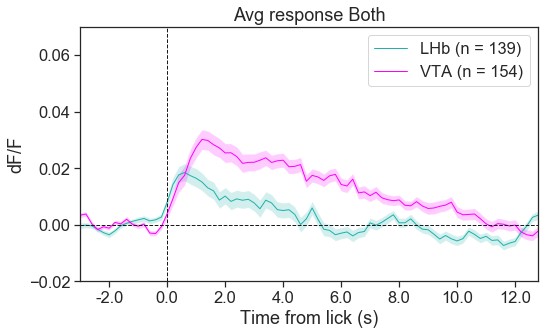

In [8]:
## Fig S4E: Population average ##
ymin=-.02
ymax=.07

avg_response1=np.nanmean(extractedsignals1_norm,axis=0)
avg_response2=np.nanmean(extractedsignals2_norm,axis=0)
peak_response1=np.nanmax(avg_response1[test[0]:test[1],:],axis=0)
peak_response2=np.nanmax(avg_response2[test[0]:test[1],:],axis=0)
avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)
avg_rew_response2=np.nanmean(avg_response2[test[0]:test[1],:],axis=0)
if save_files[0]=='yes':
    np.savetxt('Water/'+filename+'_avg_suc_response_'+condition[0]+'.csv',avg_rew_response1.T,delimiter=',')
    np.savetxt('Water/'+filename+'_avg_suc_response_'+condition[1]+'.csv',avg_rew_response2.T,delimiter=',')
    np.savetxt('Water/'+filename+'_peak_suc_response_'+condition[0]+'.csv',peak_response1.T,delimiter=',')
    np.savetxt('Water/'+filename+'_peak_suc_response_'+condition[1]+'.csv',peak_response2.T,delimiter=',')
    np.savetxt('Water/'+filename+'_all_suc_data_'+condition[0]+'.csv',avg_response1.T,delimiter=',')
    np.savetxt('Water/'+filename+'_all_suc_data_'+condition[1]+'.csv',avg_response2.T,delimiter=',')
#remove frames preceding start of baseline window
avg_response1=avg_response1[baseline[0]:,:]
avg_response2=avg_response2[baseline[0]:,:]
framespertrial=framespertrial-baseline[0]

sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 8})
fig1,ax = plt.subplots(1,1,figsize=(8,5))
sns.tsplot(avg_response1.T,color=colors[0], condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
sns.tsplot(avg_response2.T,color=colors[1], condition=condition[1]+' (n = '+str(extractedsignals2.shape[2])+')', legend=True)
ax.set_title('Avg response '+projection)
ax.set_xlabel('Time from lick (s)')
ax.set_ylabel('dF/F')
ax.set_ylim(ymin,ymax)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)])
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
fig1.tight_layout(w_pad=5)
if save_figs[0]=='yes':
    plt.savefig(('Water/'+filename+'_pop_suc_response_overlay.'+fig_style), format=str(fig_style))
    plt.show()

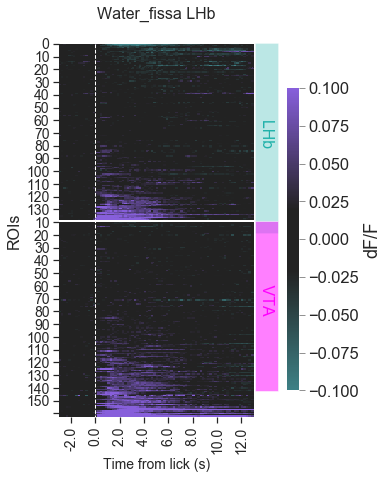

In [9]:
## Fig S4D: Population heatmaps ##
def combinedheatmap(data1,data2,title,sorton):
    ymin=-.1
    ymax=.1
    if sorton=='yes':
        sort1=np.squeeze(np.argsort(np.nanmean(data1[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data1=data1[:,sort1]
        sort2=np.squeeze(np.argsort(np.nanmean(data2[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data2=data2[:,sort2]       
    data=np.concatenate((data1,data2),axis=1)
    
    ylabel1=range(0,data1.shape[1]+1,10)
    ylabel2=range(10,data2.shape[1]+1,10)
    ylabels=ylabel1+ylabel2
    
    fig2 = plt.figure(2,figsize=(8,7))
    cbar_ax = fig2.add_axes([.52, .2, .02, .6])
    cbar_ax.tick_params(width=0.5) 
    
    ax = plt.subplot(121)
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.heatmap(data.T, cmap=cmap, vmin=ymin, vmax=ymax,linewidth=0,cbar_ax=cbar_ax,rasterized=True)
    cbar_ax.set_ylabel('dF/F')
    ax.set_title(filename+' '+str(condition[0]), fontsize=16,position=[0.5,1.05])
    ax.set_xlabel('Time from lick (s)', fontsize=14)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, data.shape[1]], '--w', linewidth=1)
    ax.axhline(y=data1.shape[1], color='white', linewidth=2)
    ax.set_yticks(range(0, data.shape[1]+1, 10))
    ax.set_yticklabels(ylabels,fontsize='14')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.ylabel('ROIs', fontsize='16')
    
    ## control text boxes
    offset=[82,12] ##related to specified plot size. change as needed
    
    ## bottom text box
    ax.text(offset[0],offset[1], '                '+condition[0]+'                  '
            ,fontsize=16,color=colors[0],rotation=270
            ,bbox={'facecolor':colors[0],'alpha':0.3,'pad':4})
    
    ## top text box
    ax.text(offset[0],offset[1]+data1.shape[1]+1, '             '+condition[1]+'                '
            ,fontsize=16,color=colors[1],rotation=270
            ,bbox={'facecolor':colors[1],'alpha':0.5,'pad':4})
    
    fig2.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(('Water/'+filename+'_'+title+'.'+fig_style), format=str(fig_style))
    plt.show()
combinedheatmap(avg_response1,avg_response2,"combined_pop_heatmap_sorted",sorton='yes')

In [10]:
## DO NOT EDIT - Function to plot bars to compare conditions ##
def bar_plot(data1,data2,ytitle,directory,param):
    if param=='Median':
        try:
            if data1.shape[1]>0:
                data1=np.nanmedian(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmedian(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmedian(data1)
        means[:,1]=np.nanmedian(data2)
        means=np.squeeze(means)
        try:
            t,p=np.around(stats.wilcoxon(data1,data2),decimals=3)
            test='Wilcoxon Rank Sum'
        except:
            t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
            test='t-test'
        sems=np.nan*np.zeros((1,2))
        sems[:,0]= stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)

    else:
        test='t-test'
        try:
            if data1.shape[1]>0:
                data1=np.nanmean(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmean(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmean(data1)
        means[:,1]=np.nanmean(data2)
        means=np.squeeze(means)
        t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
        sems=np.nan*np.zeros((1,2))
        sems[:,0]=stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)

    combinedata=np.nan*np.zeros((max(data1.shape[0],data2.shape[0]),2))
    combinedata[:data1.shape[0],0]=data1
    combinedata[:data2.shape[0],1]=data2
    np.savetxt(directory+'/'+filename+'_'+ytitle+'.csv', combinedata, delimiter=',')
    ind = (0,.5)
    width = 0.4
    fig,ax=plt.subplots(1,figsize=(3,6))
    bar=ax.bar(ind,means,width,yerr=sems,color=colors,error_kw={'ecolor':'black','linewidth':2})
    ax.set_ylabel(ytitle+' ('+param+')')
    ax.set_title(test+': '+str(t)+'  p = '+str(p),y=1,fontsize='16')
    ax.legend((bar[0],bar[1]),(condition[0],condition[1]),loc=[1.1,.5])
    ax.set_xticks([])
    if save_figs[0]=='yes':
        fig.savefig((directory+'/'+filename+'_'+ytitle+'.'+fig_style), format=str(fig_style),bbox_inches='tight')
    plt.show()

In [11]:
## DO NOT EDIT - find AUC for each neuron using trapz method and plot ##
time1=15 #frames in baseline corrected data to include in AUC calculation
time2=30
def auc(data):
    AUC=np.nan*np.zeros((data.shape[1]))
    for i in range(0,data.shape[1]):
        AUC[i] = scipy.integrate.trapz(y=data[time1:time2,i])
    return AUC
auc_condition1=auc(avg_response1)
auc_condition2=auc(avg_response2)
if save_files[0]=='yes':
    np.savetxt('Water/'+filename+'_AUC_sucrose_response_'+condition[0]+'.csv',auc_condition1.T,delimiter=',')
    np.savetxt('Water/'+filename+'_AUC_sucrose_response_'+condition[1]+'.csv',auc_condition2.T,delimiter=',')

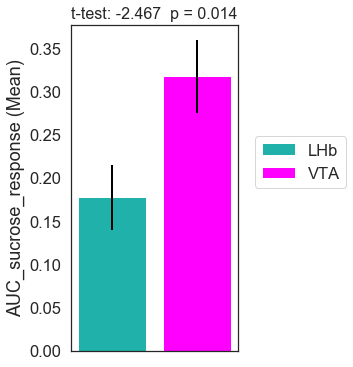

In [12]:
## Fig S4F: Compare AUC between conditions ##
bar_plot(auc_condition1,auc_condition2,'AUC_sucrose_response','Water',param='Mean')

In [13]:
## DO NOT EDIT - Function to calculate number of significant neurons ##

# type of t-test ('independent','paired', or 'wilcoxon')
#p-value (two-tailed) to consider significant
def calc_sig(basedir,test_type,sig_pvalue,which_dir):
    numtrials=maxtrials   #number of trials
    baseline_dur=(baseline[1]-baseline[0])/framerate #how long is baseline (in s)
    stimulus_dur=(test[1]-test[0])/framerate  #how long is stimulus window (in s)
    trial_length=25 #how long is each trial (in s)

    ## normalize data by baseline?
#     normalize_on=['yes']
    numpreframes=35
    numtestframes=test[1]-test[0]
    numframespertrial=100
    if which_dir==1:
        print "Condition: " + condition[0]
        label=condition[0]
    elif which_dir==2:
        print "Condition: " + condition[1]
        label=condition[1]
    rewardresponse_pop = np.zeros((maxnumneurons,2));rewardresponse_pop[:]=np.nan
    avgtrace_pop = np.zeros((maxnumneurons,numframespertrial));avgtrace_pop[:] = np.nan
    sig_excited_neurons = np.zeros((maxnumneurons,1));sig_excited_neurons[:]=np.nan
    sig_inhibited_neurons = np.zeros((maxnumneurons,1));sig_inhibited_neurons[:]=np.nan
    combine_all_data=np.zeros((maxnumneurons,numframespertrial,numtrials));combine_all_data[:]=np.nan
    listdir(basedir)

    data_dirs = os.walk(basedir).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(basedir,data_dir,lickalignfile))
        numtrials=signals.shape[0]
        signals=signals[0:numtrials,:,:]
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        reshape_response=signals

        #normalize data by baseline period
        if normalize_on[0]=='yes':
            def normalize_data(data):
                BLnorm=np.nan*np.zeros((data.shape))
                BLavg=np.nan*np.zeros((numtrials,numneurons))
                for b in range(0,numneurons):
                    for a in range(0,numtrials):
                        BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
                for e in range(0,numneurons):
                    for d in range(0,numframes):
                        for c in range(0,numtrials):
                            BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
                reshape_response=BLnorm
                return reshape_response
            reshape_response=normalize_data(reshape_response)
        else:
            reshape_response=reshape_response   
        reshape_response=np.swapaxes(reshape_response,0,2)
        avgresponse=np.nanmean(reshape_response, axis=2)

        stimulusresponse=np.zeros((numneurons,numtrials,2));stimulusresponse[:]=np.nan
        testsig_ind=np.zeros((numneurons,2))#;stats[:]=np.nan
        testsig_paired=np.zeros((numneurons,2))#;stats[:]=np.nan
        for a in range(0,numneurons):
            avgtrace_pop[numneuronstillnow+a,:]=avgresponse[a,:]
            combine_all_data[numneuronstillnow+a,:,:numtrials]=reshape_response[a,:,:numtrials]
            for b in range(0,numtrials):
                stimulusresponse[a,b,0]=np.nanmean(reshape_response[a,test[0]:test[1],b])
                stimulusresponse[a,b,1]=np.nanmean(reshape_response[a,baseline[0]:baseline[1],b])
            if test_type=='independent':
                testsig_paired[a,:]=stats.ttest_ind(stimulusresponse[a,:,0],stimulusresponse[a,:,1],equal_var=False)
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='paired':
                testsig_paired[a,:]=stats.ttest_rel(stimulusresponse[a,:,0],stimulusresponse[a,:,1])
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='wilcoxon':
                testsig_paired[a,:]=stats.wilcoxon(stimulusresponse[a,:,0],stimulusresponse[a,:,1],zero_method='wilcox')
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
        sig_excited_neurons_temp=np.zeros((numneurons,1));sig_excited_neurons_temp[:]=np.nan
        sig_inhibited_neurons_temp=np.zeros((numneurons,1));sig_inhibited_neurons_temp[:]=np.nan
        
        if test_type=='wilcoxon':
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                               np.nanmean(stimulusresponse[a,:,0],axis=0)>
                                                               np.nanmean(stimulusresponse[a,:,1],axis=0))
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                                 np.nanmean(stimulusresponse[a,:,0],axis=0)<
                                                                 np.nanmean(stimulusresponse[a,:,1],axis=0))
        else:
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[numneuronstillnow+a,0]>0,rewardresponse_pop[numneuronstillnow+a,1]<sig_pvalue) 
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[numneuronstillnow+a,0]<0,rewardresponse_pop[numneuronstillnow+a,1]<sig_pvalue) 
#                 sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]>0,rewardresponse_pop[a,1]<sig_pvalue) 
#                 sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]<0,rewardresponse_pop[a,1]<sig_pvalue) 
        sig_excited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_excited_neurons_temp
        sig_inhibited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_inhibited_neurons_temp

        numneuronstillnow += numneurons 

    ind_sig_inhibited=sig_inhibited_neurons*1
    ind_sig_excited=sig_excited_neurons*1
    ind_sig_inhibited=ind_sig_inhibited[~np.isnan(ind_sig_inhibited)]
    ind_sig_excited=ind_sig_excited[~np.isnan(ind_sig_excited)]
    roinumber=np.arange(1,numneuronstillnow+1)
    ind_sig_inhibited=np.vstack((roinumber,ind_sig_inhibited))
    ind_sig_excited=np.vstack((roinumber,ind_sig_excited))
    count_sig_inhibited_neurons=np.zeros((numneuronstillnow,1));count_sig_inhibited_neurons[:]=np.nan
    count_sig_excited_neurons=np.zeros((numneuronstillnow,1));count_sig_excited_neurons[:]=np.nan

    for a in range(0,numneuronstillnow-1):
        if ind_sig_inhibited[1,a]>0:
            count_sig_inhibited_neurons[a,:]=ind_sig_inhibited[0,a]
        if ind_sig_excited[1,a]>0:
            count_sig_excited_neurons[a,:]=ind_sig_excited[0,a]

    count_sig_inhibited_neurons=count_sig_inhibited_neurons[~np.isnan(count_sig_inhibited_neurons)]
    count_sig_excited_neurons=count_sig_excited_neurons[~np.isnan(count_sig_excited_neurons)]

    find_sig_excited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_excited_neurons[:]=np.nan
    find_sig_inhibited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_inhibited_neurons[:]=np.nan
    find_sig_neurons=np.zeros(avgtrace_pop.shape);find_sig_neurons[:]=np.nan
    sig_excited_pop=np.zeros((combine_all_data.shape));sig_excited_pop[:]=np.nan
    sig_inhibited_pop=np.zeros(combine_all_data.shape);sig_inhibited_pop[:]=np.nan
    for a in range(0,numneuronstillnow):
        if sig_excited_neurons[a]==True:
            find_sig_excited_neurons[a,:]=avgtrace_pop[a,:]
            sig_excited_pop[a,:]=combine_all_data[a,:]
        if sig_inhibited_neurons[a]==True:
            find_sig_inhibited_neurons[a,:]=avgtrace_pop[a,:]  
            sig_inhibited_pop[a,:]=combine_all_data[a,:]
    mask_excited = np.all(np.isnan(find_sig_excited_neurons) | np.equal(find_sig_excited_neurons, 0), axis=1)
    plot_sig_excited_neurons=find_sig_excited_neurons[~mask_excited]
    mask_inhibited = np.all(np.isnan(find_sig_inhibited_neurons) | np.equal(find_sig_inhibited_neurons, 0), axis=1)
    plot_sig_inhibited_neurons=find_sig_inhibited_neurons[~mask_inhibited]
    mask_excited_pop = np.all(np.isnan(sig_excited_pop) | np.equal(sig_excited_pop, 0), axis=2)
    save_excited_pop=sig_excited_pop[~mask_excited_pop]
    mask_inhibited_pop = np.all(np.isnan(sig_inhibited_pop) | np.equal(sig_inhibited_pop, 0), axis=2)
    save_inhibited_pop=sig_inhibited_pop[~mask_inhibited_pop]

    peakresponse=np.zeros((numneuronstillnow,1));peakresponse[:]=np.nan
    for a in range(0,numneuronstillnow):
        peakresponse[a,:]=np.max(avgtrace_pop[a,test[0]:test[1]])
    if save_files[0]=='yes':
        np.savetxt('Water/'+filename+'_Peak_Response.csv', peakresponse,delimiter=',') 
        np.save('Water/'+filename+'_AVG_pop_data',avgtrace_pop)
        np.save('Water/'+filename+'_pop_data',combine_all_data[:numneuronstillnow-1,:,:])
    ##plot pie chart of responses
    labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
    colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)]
    explode=(0, .2, .2)
    frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
    positiveresponders = len(count_sig_excited_neurons)
    negativeresponders = len(count_sig_inhibited_neurons)
    noresponders = numneuronstillnow-(positiveresponders+negativeresponders)
    frequency_response = np.array([noresponders, positiveresponders, negativeresponders])
    frequency_population[:,0] = frequency_response
    print "Projection: "+projection
    print "Test: "+test_type, "| P threshold: "+str(sig_pvalue)
    print "Excited = ",positiveresponders
    print "Inhibited = ",negativeresponders
    print "Null = ",noresponders
    fig8,ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(filename+' '+projection+' '+' '+label+' within condition', y=1)
    ax1.pie(frequency_response, explode=explode, autopct='%1.0f%%',
            shadow=True, startangle=45, colors=colors)
    plt.tight_layout()
    if save_figs[0]=='yes':
        plt.savefig(('Water/'+filename+' '+label+'_pie_within_condition.'+fig_style), format=str(fig_style))
    plt.show()
    
    return ind_sig_excited,ind_sig_inhibited

Condition: LHb
Projection: Both
Test: paired | P threshold: 0.05
Excited =  37
Inhibited =  14
Null =  88


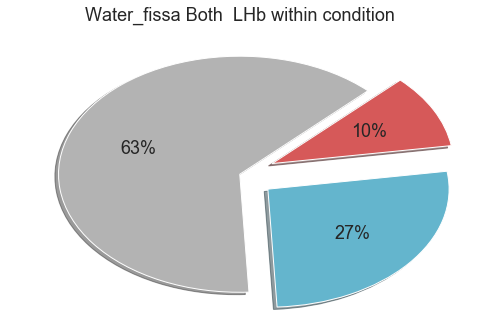

Condition: VTA
Projection: Both
Test: paired | P threshold: 0.05
Excited =  70
Inhibited =  4
Null =  80


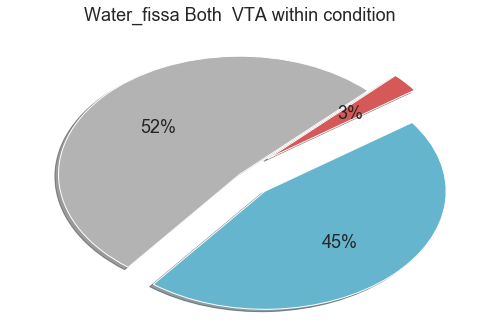

In [14]:
## Fig S4G: Calculate number of significant responders ##    
sige1,sigi1=calc_sig(basedir=basedir1,test_type='paired',sig_pvalue=0.05, which_dir=1)
sige2,sigi2=calc_sig(basedir=basedir2,test_type='paired',sig_pvalue=0.05, which_dir=2)

# This section is for plotting lick behavior data ##

In [15]:
## DO NOT EDIT - Function to align lick data to first lick after reward and plot ##
def align_licks(basedir):  
    numtrialstillnow=0
    alllickdata=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarate=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarew=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarewrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    latency=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(basedir).next()[1]
    licktotal=np.nan*np.zeros((len(data_dirs))) ; q=0
    for data_dir in data_dirs:
        try:
            behaviordata=sio.loadmat(os.path.join(basedir,data_dir,'behavior.mat'))
        except:
            continue
        cues=np.squeeze(behaviordata['cues'])
        licks=np.squeeze(behaviordata['licks'])
        t_fxd=np.squeeze(behaviordata['fxdpumps'])#/1000 #in seconds
        eventlog = behaviordata['eventlog']
        tempframes = eventlog[eventlog[:,0]==9,1]
        frameaveraging = 6
        framerate = 30.0/frameaveraging #for resonant scanner, maximum rate is 30Hz
        frames = tempframes[::frameaveraging]
        cuesplus=cues[cues>0]
        
        ## calculate first lick after reward. limit to licks occurring within 15s of rew delivery. 
        firstlickafterCSplus=np.nan*np.zeros((len(t_fxd)))
        for a in range(0,len(t_fxd)):
            try:
                if t_fxd[a]-licks[licks>t_fxd[a]][1] < -10000:
                    firstlickafterCSplus[a] = np.nan
                elif t_fxd[a]-licks[licks>t_fxd[a]][0] == -51:
                    firstlickafterCSplus[a] = licks[licks>t_fxd[a]][1] #use second lick to avoid solenoid artifact
                else:
                    firstlickafterCSplus[a] = licks[licks>t_fxd[a]][1] #use second lick to avoid solenoid artifact
            except:
                firstlickafterCSplus[a]=np.nan
        
        ## remove lick artifact from 'licks' ##
        removelicks=np.nan*np.zeros((0))
        for a in range(len(t_fxd)):
            templicks=licks[np.logical_and(licks>t_fxd[a], licks<firstlickafterCSplus[a])]
            removelicks=np.append(removelicks, templicks)
        licks=licks[~np.isin(licks,removelicks)]
        licktotal[q]=len(licks) ; q+=1
        
        ## calculate latency to lick after reward delivery
        latency_temp=np.nan*np.zeros((maxtrials))
        for i in range(len(t_fxd)):
            latency_temp[i]=(firstlickafterCSplus[i]-t_fxd[i])/1000
   
        ##find frame numbers
        def framenumberforevent(event):
            framenumber = np.nan*np.zeros(event.shape)
            for ie, e in enumerate(event):
                try:
                    framenumber[ie] = np.nonzero(frames<=e)[0][-1]
                except:
                    pass
            return framenumber
        framenumberforcuesplus = np.squeeze(framenumberforevent(cuesplus))
        framenumberforlicks = np.squeeze(framenumberforevent(licks))
        framenumberforCSpluslick = np.squeeze(framenumberforevent(firstlickafterCSplus))
        framenumberforrew=np.squeeze(framenumberforevent(t_fxd))
        framenumberforCSpluslick=framenumberforCSpluslick[~np.isnan(framenumberforCSpluslick)]
        lickframes=np.zeros((maxtrials*125))
        lickframesrate=np.zeros((maxtrials*125))
        framesall=np.arange(0,lickframes.shape[0])
        numtimesampleslick = 80 #How many do you want to plot around the cue?
        
        for a in range(0,len(framesall)):
            for b in range(0,len(framenumberforlicks)):
                if framenumberforlicks[b]==framesall[a]:
                    lickframes[a]=1 
                    lickframesrate[a]=lickframesrate[a]+1
        lickframesrate=lickframesrate*framerate
        alignlick_behavior = np.zeros([maxtrials,framespertrial]) #for lick probability lick aligned
        alignlick_rate = np.zeros([maxtrials,framespertrial]) #for lick rate lick aligned
        alignlick_rew=np.zeros([maxtrials,framespertrial]) #for lick probability reward aligned
        alignlick_rewrate=np.zeros([maxtrials,framespertrial]) #for lick rate reward aligned

        for i in range(framenumberforCSpluslick.shape[0]):
            try:
                alignlick_behavior[i,:]= lickframes[int(framenumberforCSpluslick[i]-baseline[0]):int(framenumberforCSpluslick[i]+numtimesampleslick-baseline[0])]
                alignlick_rate[i,:]= lickframesrate[int(framenumberforCSpluslick[i]-baseline[0]):int(framenumberforCSpluslick[i]+numtimesampleslick-baseline[0])]
                alignlick_rew[i,:]= lickframes[int(framenumberforrew[i]-baseline[0]):int(framenumberforrew[i]+numtimesampleslick-baseline[0])]
                alignlick_rewrate[i,:]= lickframesrate[int(framenumberforrew[i]-baseline[0]):int(framenumberforrew[i]+numtimesampleslick-baseline[0])]
            except:
                templen=lickframes[int(framenumberforCSpluslick[i]-baseline[0]):].shape[0]
                alignlick_behavior[i,:templen]= lickframes[int(framenumberforCSpluslick[i]-baseline[0]):]
                alignlick_rate[i,:templen]= lickframesrate[int(framenumberforCSpluslick[i]-baseline[0]):]
        numtrialstillnow += maxtrials
    
        alllickdata[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_behavior[:,:]
        alllickdatarate[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rate[:,:]
        alllickdatarew[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rew[:,:]
        alllickdatarewrate[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rewrate[:,:]
        latency[numtrialstillnow-maxtrials:numtrialstillnow]=latency_temp
    
    latency=latency[:numtrialstillnow];latency=latency[~np.isnan(latency)]
    alllickdata=alllickdata[:numtrialstillnow,:]
    alllickdatarew=alllickdatarew[:numtrialstillnow,:]
    alllickdatarate=alllickdatarate[:numtrialstillnow,:]
    alllickdatarewrate=alllickdatarewrate[:numtrialstillnow,:]
    return alllickdata,alllickdatarew,latency,licktotal,alllickdatarate,alllickdatarewrate  
        
alignlicks1,rewalignlicks1,latency1,licktotal1,alignlickrate1,rewalignrate1=align_licks(basedir1)
alignlicks2,rewalignlicks2,latency2,licktotal2,alignlickrate2,rewalignrate2=align_licks(basedir2)

In [16]:
## DO NOT EDIT - Funciton to plot lick data ##
def plotlickdata(data1,data2,xtitle,ylim,ylabel):
    fontsize=20
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 8})
    f,ax = plt.subplots(1,1,figsize=(10,5))
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    sns.tsplot(data1[:,10:], color=colors[0], condition=condition[0], legend=True)
    sns.tsplot(data2[:,10:], color=colors[1], condition=condition[1], legend=True)
    ax.set_title(filename+' lick rate '+projection,fontsize=fontsize)
    ax.set_xlabel(xtitle+' (s)',fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_yticks(np.arange(ylim[0],ylim[1]+1,ylim[1]/2))
    ax.set_yticklabels(np.arange(ylim[0],ylim[1]+1,ylim[1]/2),fontsize=fontsize)
    ax.set_xticks(range(10, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=fontsize)
    ax.set_ylim([ylim[0],ylim[1]+.05])
    f.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(('Behavior/'+filename+'_'+xtitle+'_'+ylabel+'.'+fig_style), format=str(fig_style))
        plt.show()

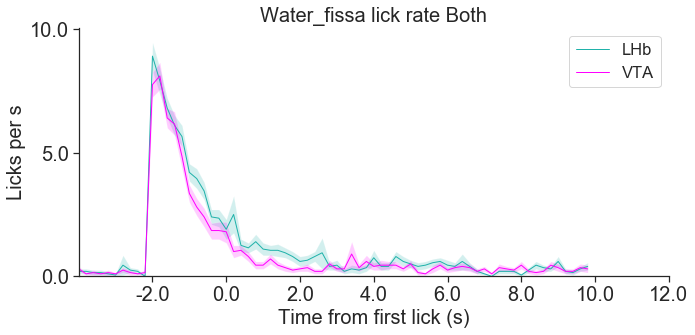

In [17]:
## Fig S4B: Plot lick data ##
plotlickdata(alignlickrate1,alignlickrate2,'Time from first lick',ylim=[0,10],ylabel='Licks per s')